In [11]:
import os
import cv2
from sklearn.model_selection import train_test_split

# Define paths
base_dir = 'Final'
all_files_dir = os.path.join(base_dir, 'data')
all_files = os.listdir(all_files_dir)

# Filter images and annotations
all_images = [f for f in all_files if f.endswith('.PNG')]
all_annotations = [f.replace('.PNG', '.txt') for f in all_images]

# Function to parse annotations and get unique classes
def parse_annotations(annotation_file):
    boxes = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Get unique classes
unique_classes = sorted(list(set([int(line.split()[0]) for annotation in all_annotations for line in open(os.path.join(all_files_dir, annotation)).readlines()])))
class_names = {i: f'class_{i}' for i in unique_classes}

print("Unique classes found:", class_names)


Unique classes found: {0: 'class_0', 1: 'class_1'}


In [12]:
# Create directories for each class
for class_name in class_names.values():
    os.makedirs(os.path.join(base_dir, 'cropped', 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'cropped', 'val', class_name), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'cropped', 'test', class_name), exist_ok=True)

# Function to crop images and save them
def crop_and_save_images(images, annotations, src_dir, dst_dir):
    for image, annotation in zip(images, annotations):
        image_path = os.path.join(src_dir, image)
        img = cv2.imread(image_path)
        height, width, _ = img.shape

        boxes = parse_annotations(os.path.join(src_dir, annotation))
        for idx, (class_id, x_center, y_center, box_width, box_height) in enumerate(boxes):
            x_min = int((x_center - box_width / 2) * width)
            x_max = int((x_center + box_width / 2) * width)
            y_min = int((y_center - box_height / 2) * height)
            y_max = int((y_center + box_height / 2) * height)
            
            cropped_img = img[y_min:y_max, x_min:x_max]
            class_name = class_names[class_id]
            save_path = os.path.join(dst_dir, class_name, f'{os.path.splitext(image)[0]}_{idx}.png')
            cv2.imwrite(save_path, cropped_img)

# Split the data
train_images, temp_images, train_annotations, temp_annotations = train_test_split(all_images, all_annotations, test_size=0.4, random_state=42)
val_images, test_images, val_annotations, test_annotations = train_test_split(temp_images, temp_annotations, test_size=0.5, random_state=42)

# Crop and save images to respective directories
crop_and_save_images(train_images, train_annotations, all_files_dir, os.path.join(base_dir, 'cropped', 'train'))
crop_and_save_images(val_images, val_annotations, all_files_dir, os.path.join(base_dir, 'cropped', 'val'))
crop_and_save_images(test_images, test_annotations, all_files_dir, os.path.join(base_dir, 'cropped', 'test'))

print('Images cropped and saved successfully!')


Images cropped and saved successfully!


In [13]:
import os
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
input_shape = (224, 224, 3)
batch_size = 32

# Data Generators with Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'cropped', 'train'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'cropped', 'val'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'cropped', 'test'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4214 images belonging to 2 classes.
Found 1448 images belonging to 2 classes.
Found 1375 images belonging to 2 classes.


In [14]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load Pre-trained GoogLeNet (InceptionV3) Model and Modify It
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model_googlenet = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model_googlenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
model_googlenet.fit(train_generator, epochs=50, validation_data=val_generator)

# Save the Model
model_googlenet.save('traffic_model_googlenet.h5')

# Evaluate the Model
evaluation_googlenet = model_googlenet.evaluate(test_generator)
print(f'GoogLeNet Test loss: {evaluation_googlenet[0]}, Test accuracy: {evaluation_googlenet[1]}')


Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.7644 - loss: 0.8156 - val_accuracy: 0.9247 - val_loss: 0.2015
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.9361 - loss: 0.1761 - val_accuracy: 0.9482 - val_loss: 0.1461
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.9317 - loss: 0.1645 - val_accuracy: 0.9413 - val_loss: 0.1596
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9449 - loss: 0.1599 - val_accuracy: 0.9151 - val_loss: 0.2274
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9456 - loss: 0.1452 - val_accuracy: 0.9517 - val_loss: 0.1397
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.9470 - loss: 0.1365 - val_accuracy: 0.9489 - val_loss: 0.1395
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9386 - loss: 0.1613 - val_accuracy: 0.9399 - val_loss: 0.1524
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9500 - loss: 0.1388 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9712 - loss: 0.0732
GoogLeNet Test loss: 0.06548847258090973, Test accuracy: 0.9752727150917053


In [15]:
from tensorflow.keras.applications import ResNet50

# Load Pre-trained ResNet50 Model and Modify It
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
model_resnet.fit(train_generator, epochs=50, validation_data=val_generator)

# Save the Model
model_resnet.save('traffic_model_resnet.h5')

# Evaluate the Model
evaluation_resnet = model_resnet.evaluate(test_generator)
print(f'ResNet Test loss: {evaluation_resnet[0]}, Test accuracy: {evaluation_resnet[1]}')


Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 511s 4s/step - accuracy: 0.6349 - loss: 0.7966 - val_accuracy: 0.3052 - val_loss: 0.7104
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.6758 - loss: 0.6401 - val_accuracy: 0.7486 - val_loss: 0.6392
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - accuracy: 0.6893 - loss: 0.6206 - val_accuracy: 0.6948 - val_loss: 0.5713
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - accuracy: 0.7131 - loss: 0.5906 - val_accuracy: 0.6948 - val_loss: 0.5726
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - accuracy: 0.7225 - loss: 0.5660 - val_accuracy: 0.7465 - val_loss: 0.5533
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 497s 4s/step - accuracy: 0.7207 - loss: 0.5858 - val_accuracy: 0.7680 - val_loss: 0.5559
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 499s 4s/step - accuracy: 0.7165 - loss: 0.5755 - val_accuracy: 0.7224 - val_loss: 0.5355
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 497s 4s/step - accuracy: 0.7125 - loss: 0.5768 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.8385 - loss: 0.4169
ResNet Test loss: 0.4356546103954315, Test accuracy: 0.8189091086387634


In [16]:
from tensorflow.keras.applications import MobileNetV2

# Load Pre-trained MobileNetV2 Model and Modify It
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
model_mobilenet.fit(train_generator, epochs=50, validation_data=val_generator)

# Save the Model
model_mobilenet.save('traffic_model_mobilenet.h5')

# Evaluate the Model
evaluation_mobilenet = model_mobilenet.evaluate(test_generator)
print(f'MobileNet Test loss: {evaluation_mobilenet[0]}, Test accuracy: {evaluation_mobilenet[1]}')


Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.8601 - loss: 0.4456 - val_accuracy: 0.9669 - val_loss: 0.1111
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9607 - loss: 0.1152 - val_accuracy: 0.9558 - val_loss: 0.1367
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9617 - loss: 0.1123 - val_accuracy: 0.9765 - val_loss: 0.0763
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9730 - loss: 0.0739 - val_accuracy: 0.9496 - val_loss: 0.1279
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9675 - loss: 0.0943 - val_accuracy: 0.9738 - val_loss: 0.0819
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9738 - loss: 0.0736 - val_accuracy: 0.9793 - val_loss: 0.0622
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9774 - loss: 0.0690 - val_accuracy: 0.9772 - val_loss: 0.0666
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9738 - loss: 0.0762 - val_accu

43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 661ms/step - accuracy: 0.9768 - loss: 0.1094
MobileNet Test loss: 0.09381826221942902, Test accuracy: 0.9745454788208008


In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
input_shape = (224, 224, 3)
batch_size = 32

# Data Generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'cropped', 'test'),
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1375 images belonging to 2 classes.


In [18]:
from tensorflow.keras.models import load_model
import numpy as np

# Load trained models
model_googlenet = load_model('traffic_model_googlenet.h5')
model_resnet = load_model('traffic_model_resnet.h5')
model_mobilenet = load_model('traffic_model_mobilenet.h5')

# Make predictions
def get_predictions_and_labels(model, generator):
    steps = generator.samples // generator.batch_size
    predictions = model.predict(generator, steps=steps, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes[:len(y_pred)]
    return y_true, y_pred

y_true_googlenet, y_pred_googlenet = get_predictions_and_labels(model_googlenet, test_generator)
y_true_resnet, y_pred_resnet = get_predictions_and_labels(model_resnet, test_generator)
y_true_mobilenet, y_pred_mobilenet = get_predictions_and_labels(model_mobilenet, test_generator)


42/42 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 665ms/step


In [19]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

# Function to compute metrics
def compute_metrics(y_true, y_pred, class_names):
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Classification Report
    class_report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Precision, Recall, F1 Score
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1_score = class_report['weighted avg']['f1-score']
    
    # AUC (one-vs-rest)
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
    y_pred_bin = tf.keras.utils.to_categorical(y_pred, num_classes=len(class_names))
    roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')
    
    return conf_matrix, precision, recall, f1_score, roc_auc

# Compute metrics for each model
conf_matrix_googlenet, precision_googlenet, recall_googlenet, f1_score_googlenet, roc_auc_googlenet = compute_metrics(y_true_googlenet, y_pred_googlenet, list(class_names.values()))
conf_matrix_resnet, precision_resnet, recall_resnet, f1_score_resnet, roc_auc_resnet = compute_metrics(y_true_resnet, y_pred_resnet, list(class_names.values()))
conf_matrix_mobilenet, precision_mobilenet, recall_mobilenet, f1_score_mobilenet, roc_auc_mobilenet = compute_metrics(y_true_mobilenet, y_pred_mobilenet, list(class_names.values()))

# Print the results
print("GoogLeNet Performance:")
print("Confusion Matrix:\n", conf_matrix_googlenet)
print("Precision:", precision_googlenet)
print("Recall:", recall_googlenet)
print("F1 Score:", f1_score_googlenet)
print("ROC AUC:", roc_auc_googlenet)

print("\nResNet Performance:")
print("Confusion Matrix:\n", conf_matrix_resnet)
print("Precision:", precision_resnet)
print("Recall:", recall_resnet)
print("F1 Score:", f1_score_resnet)
print("ROC AUC:", roc_auc_resnet)

print("\nMobileNet Performance:")
print("Confusion Matrix:\n", conf_matrix_mobilenet)
print("Precision:", precision_mobilenet)
print("Recall:", recall_mobilenet)
print("F1 Score:", f1_score_mobilenet)
print("ROC AUC:", roc_auc_mobilenet)


GoogLeNet Performance:
Confusion Matrix:
 [[402  30]
 [  4 908]]
Precision: 0.9751305051099183
Recall: 0.9747023809523809
F1 Score: 0.9744877028409249
ROC AUC: 0.9630847953216373

ResNet Performance:
Confusion Matrix:
 [[226 206]
 [ 38 874]]
Precision: 0.8243025493025493
Recall: 0.8184523809523809
F1 Score: 0.804197083902111
ROC AUC: 0.7407407407407408

MobileNet Performance:
Confusion Matrix:
 [[407  25]
 [  9 903]]
Precision: 0.97476553618795
Recall: 0.9747023809523809
F1 Score: 0.9745737138169459
ROC AUC: 0.9661306042884991


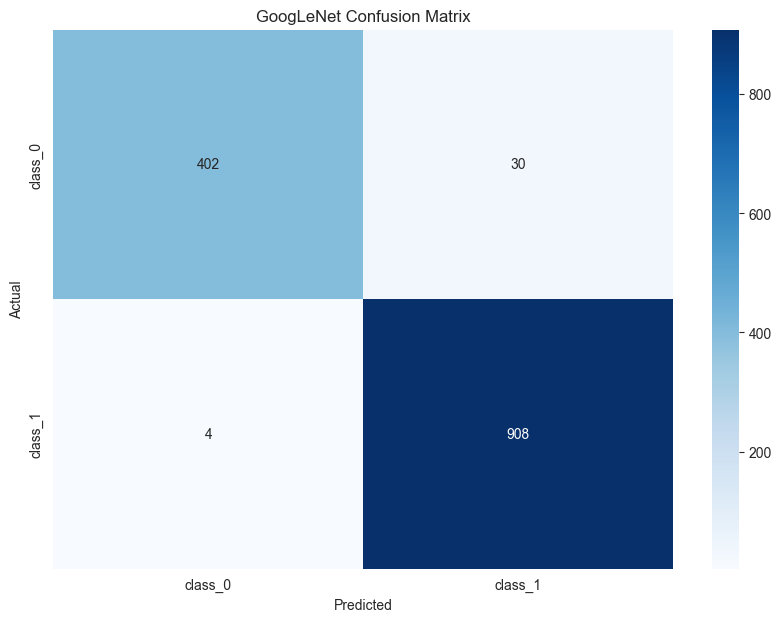

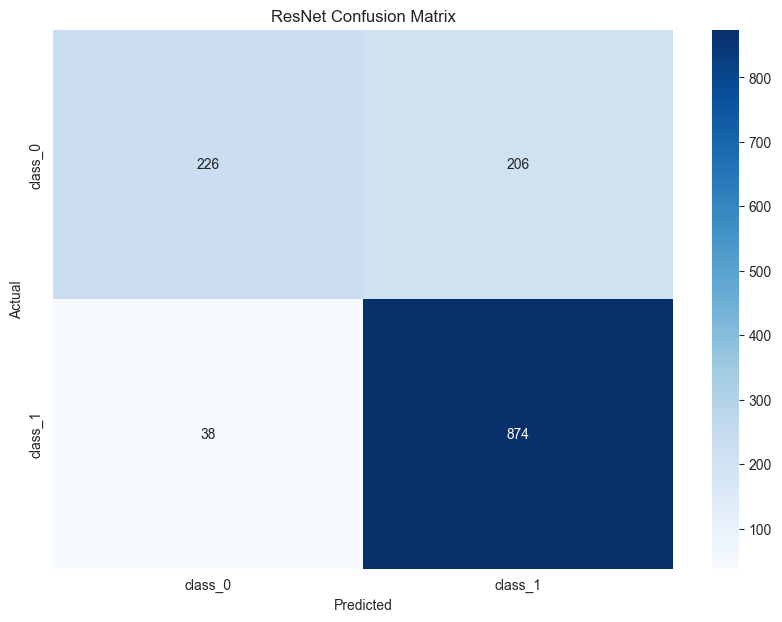

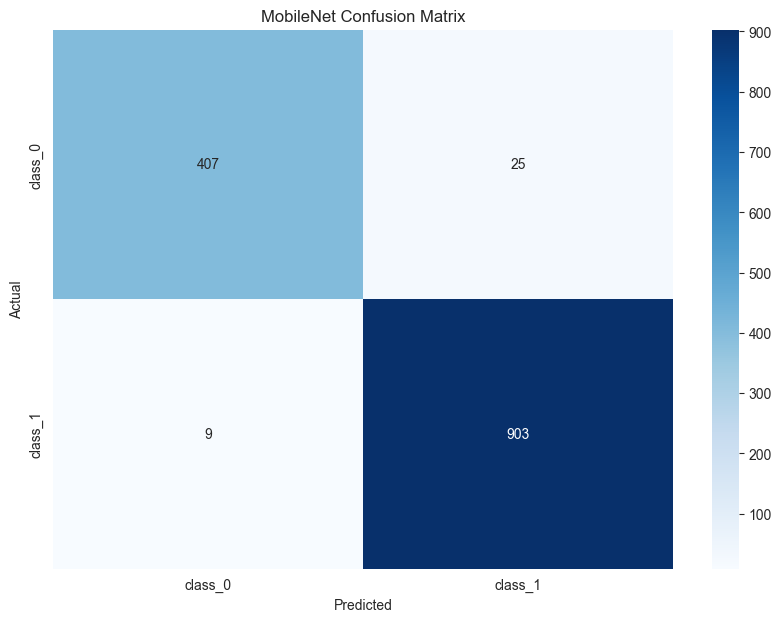

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot Confusion Matrices for all models
plot_confusion_matrix(conf_matrix_googlenet, list(class_names.values()), title='GoogLeNet Confusion Matrix')
plot_confusion_matrix(conf_matrix_resnet, list(class_names.values()), title='ResNet Confusion Matrix')
plot_confusion_matrix(conf_matrix_mobilenet, list(class_names.values()), title='MobileNet Confusion Matrix')


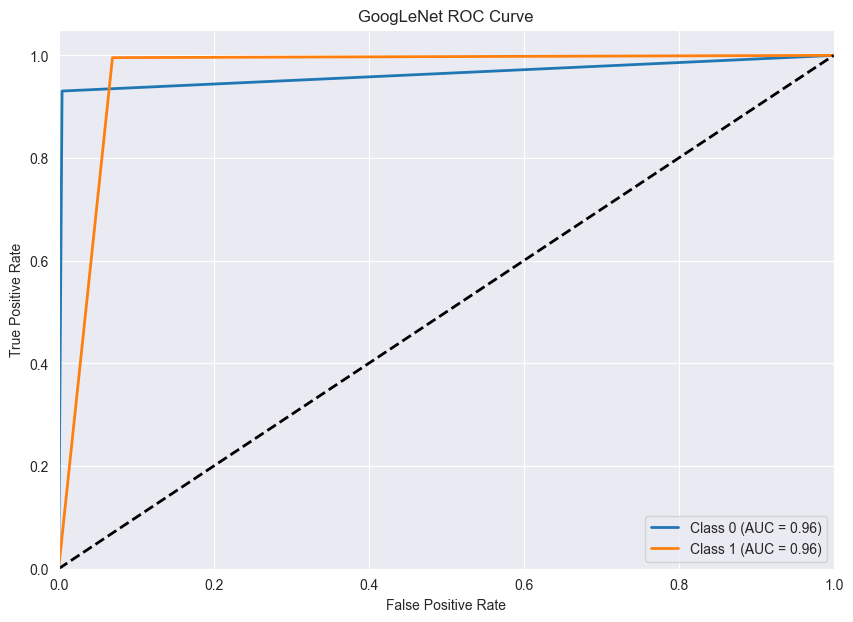

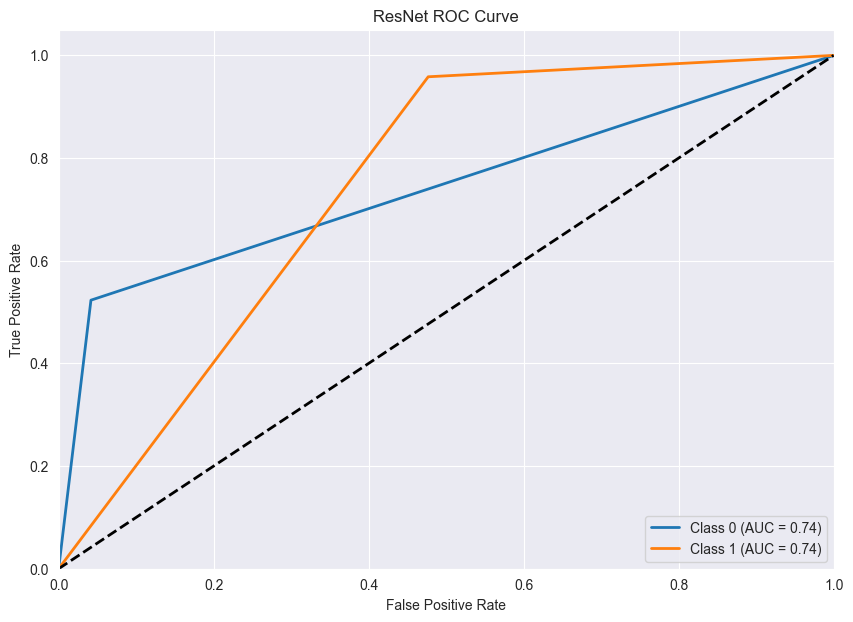

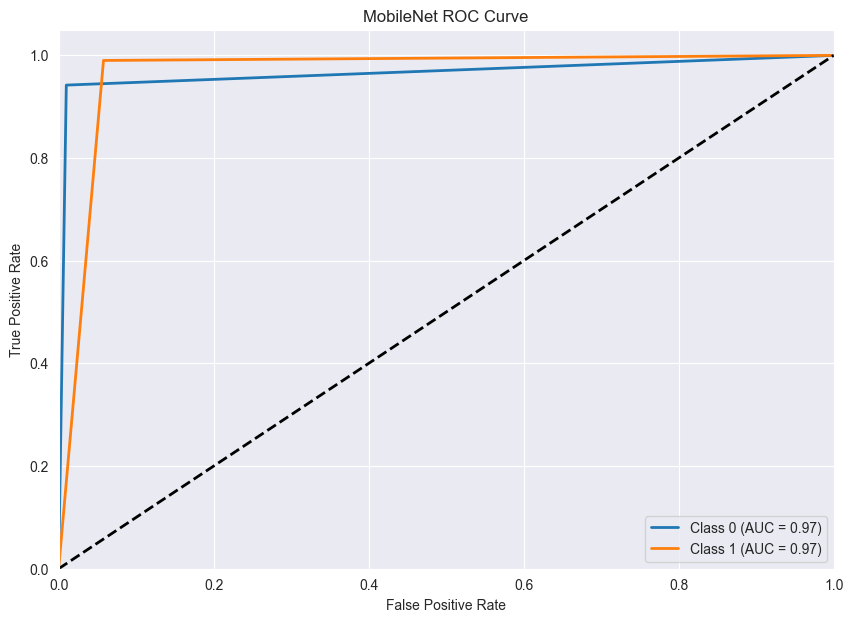

In [21]:
from sklearn.metrics import roc_curve

def plot_roc_auc(y_true, y_pred, n_classes, title='ROC Curve'):
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)
    y_pred_bin = tf.keras.utils.to_categorical(y_pred, num_classes=n_classes)
    plt.figure(figsize=(10, 7))
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC Curves for all models
plot_roc_auc(y_true_googlenet, y_pred_googlenet, len(class_names), title='GoogLeNet ROC Curve')
plot_roc_auc(y_true_resnet, y_pred_resnet, len(class_names), title='ResNet ROC Curve')
plot_roc_auc(y_true_mobilenet, y_pred_mobilenet, len(class_names), title='MobileNet ROC Curve')


    Model  Precision  Recall  F1 Score  ROC AUC
GoogLeNet     0.9751  0.9747    0.9745   0.9631
   ResNet     0.8243  0.8185    0.8042   0.7407
MobileNet     0.9748  0.9747    0.9746   0.9661


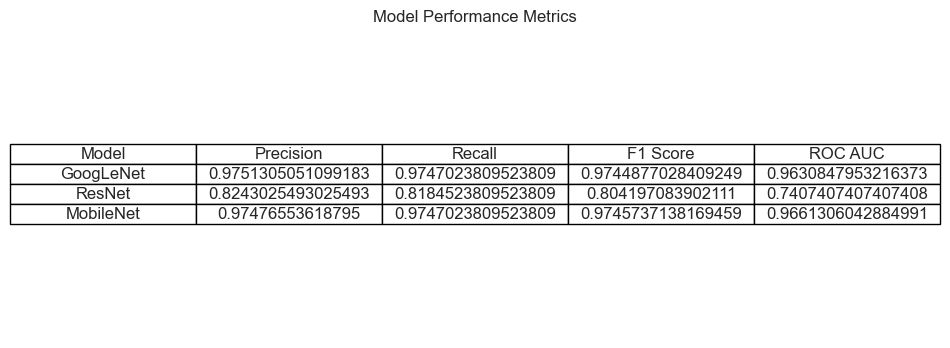

In [22]:
import pandas as pd

# Create DataFrame to display metrics
metrics_data = {
    'Model': ['GoogLeNet', 'ResNet', 'MobileNet'],
    'Precision': [precision_googlenet, precision_resnet, precision_mobilenet],
    'Recall': [recall_googlenet, recall_resnet, recall_mobilenet],
    'F1 Score': [f1_score_googlenet, f1_score_resnet, f1_score_mobilenet],
    'ROC AUC': [roc_auc_googlenet, roc_auc_resnet, roc_auc_mobilenet]
}

metrics_df = pd.DataFrame(metrics_data)

# Display the table with precision to 4 decimal places
metrics_table = metrics_df.to_string(index=False, float_format=lambda x: '{:.4f}'.format(x))

print(metrics_table)

# Plotting the table
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.title('Model Performance Metrics')
plt.show()


In [23]:
from tensorflow.keras.models import load_model
import numpy as np

# Load trained models
model_googlenet = load_model('traffic_model_googlenet.h5')
model_resnet = load_model('traffic_model_resnet.h5')
model_mobilenet = load_model('traffic_model_mobilenet.h5')

# Make predictions
def get_predictions_and_labels(model, generator):
    steps = generator.samples // generator.batch_size
    predictions = model.predict(generator, steps=steps, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes[:len(y_pred)]
    return y_true, y_pred

# Function to evaluate model performance
def evaluate_model_performance(y_true, y_pred):
    # Calculate accuracy
    accuracy = np.mean(y_true == y_pred)
    # Calculate precision, recall, F1-score, etc. (if needed)
    # Add additional evaluation metrics as required
    return accuracy

# Evaluate performance of GoogleNet model
y_true_googlenet, y_pred_googlenet = get_predictions_and_labels(model_googlenet, test_generator)
accuracy_googlenet = evaluate_model_performance(y_true_googlenet, y_pred_googlenet)

# Evaluate performance of ResNet model
y_true_resnet, y_pred_resnet = get_predictions_and_labels(model_resnet, test_generator)
accuracy_resnet = evaluate_model_performance(y_true_resnet, y_pred_resnet)

# Evaluate performance of MobileNet model
y_true_mobilenet, y_pred_mobilenet = get_predictions_and_labels(model_mobilenet, test_generator)
accuracy_mobilenet = evaluate_model_performance(y_true_mobilenet, y_pred_mobilenet)

# Print model performance
print("GoogleNet Accuracy:", accuracy_googlenet)
print("ResNet Accuracy:", accuracy_resnet)
print("MobileNet Accuracy:", accuracy_mobilenet)


42/42 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 645ms/step
GoogleNet Accuracy: 0.9747023809523809
ResNet Accuracy: 0.8184523809523809
MobileNet Accuracy: 0.9747023809523809


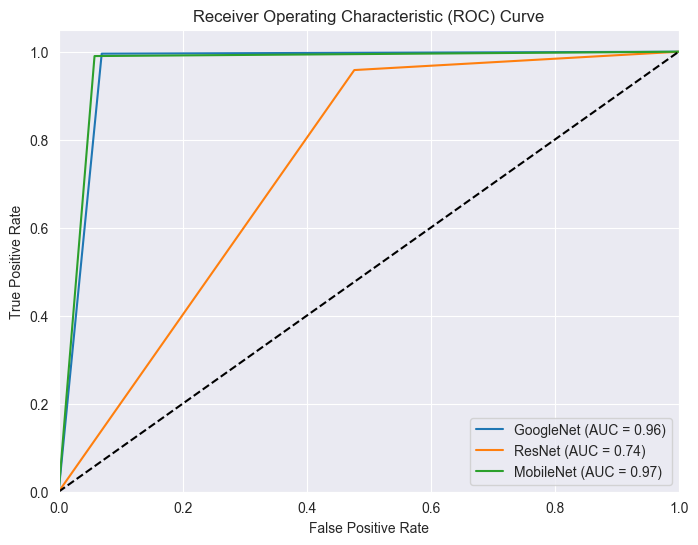

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate AUC for all models
def calculate_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Plot ROC curve
def plot_roc_curve(fprs, tprs, aucs, model_names):
    plt.figure(figsize=(8, 6))
    for i in range(len(model_names)):
        plt.plot(fprs[i], tprs[i], label=f'{model_names[i]} (AUC = {aucs[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Calculate AUC for GoogleNet
fpr_googlenet, tpr_googlenet, auc_googlenet = calculate_auc(y_true_googlenet, y_pred_googlenet)

# Calculate AUC for ResNet
fpr_resnet, tpr_resnet, auc_resnet = calculate_auc(y_true_resnet, y_pred_resnet)

# Calculate AUC for MobileNet
fpr_mobilenet, tpr_mobilenet, auc_mobilenet = calculate_auc(y_true_mobilenet, y_pred_mobilenet)

# Plot ROC curve for all models
plot_roc_curve([fpr_googlenet, fpr_resnet, fpr_mobilenet],
               [tpr_googlenet, tpr_resnet, tpr_mobilenet],
               [auc_googlenet, auc_resnet, auc_mobilenet],
               ['GoogleNet', 'ResNet', 'MobileNet'])


In [27]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Function to add a simple attention mechanism
def attention_module(input_tensor):
    input_shape = input_tensor.shape[-1]
    attention = Dense(input_shape, activation='sigmoid')(input_tensor)
    return Multiply()([input_tensor, attention])

# Define the input shape
input_shape = (224, 224, 3)
class_names = ['class_0', 'class_1']  # Ensure this matches the number of classes

# Load MobileNetV2 without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Add Global Average Pooling
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add Attention Module
x = attention_module(x)

# Add a dense layer followed by output layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the model
model_mobilenet_attention = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_mobilenet_attention.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Assume train_generator, val_generator, and test_generator are predefined Keras data generators
# Train the model
model_mobilenet_attention.fit(train_generator, epochs=50, validation_data=val_generator)

# Save the model
model_mobilenet_attention.save('traffic_model_mobilenet_attention.h5')

# Evaluate the model
evaluation_mobilenet_attention = model_mobilenet_attention.evaluate(test_generator)
print(f'MobileNet with Attention Test loss: {evaluation_mobilenet_attention[0]}, Test accuracy: {evaluation_mobilenet_attention[1]}')


Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 130s 932ms/step - accuracy: 0.7928 - loss: 0.4965 - val_accuracy: 0.9696 - val_loss: 0.1013
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9655 - loss: 0.1090 - val_accuracy: 0.9544 - val_loss: 0.1229
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9577 - loss: 0.1022 - val_accuracy: 0.9800 - val_loss: 0.0687
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9691 - loss: 0.0769 - val_accuracy: 0.9717 - val_loss: 0.1033
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9726 - loss: 0.0768 - val_accuracy: 0.9758 - val_loss: 0.0714
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9842 - loss: 0.0535 - val_accuracy: 0.9710 - val_loss: 0.0806
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9719 - loss: 0.0692 - val_accuracy: 0.9689 - val_loss: 0.1124
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9737 - loss: 0.0683 - val_a

43/43 ━━━━━━━━━━━━━━━━━━━━ 29s 683ms/step - accuracy: 0.9626 - loss: 0.1887
MobileNet with Attention Test loss: 0.07385162264108658, Test accuracy: 0.984000027179718


43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 705ms/step


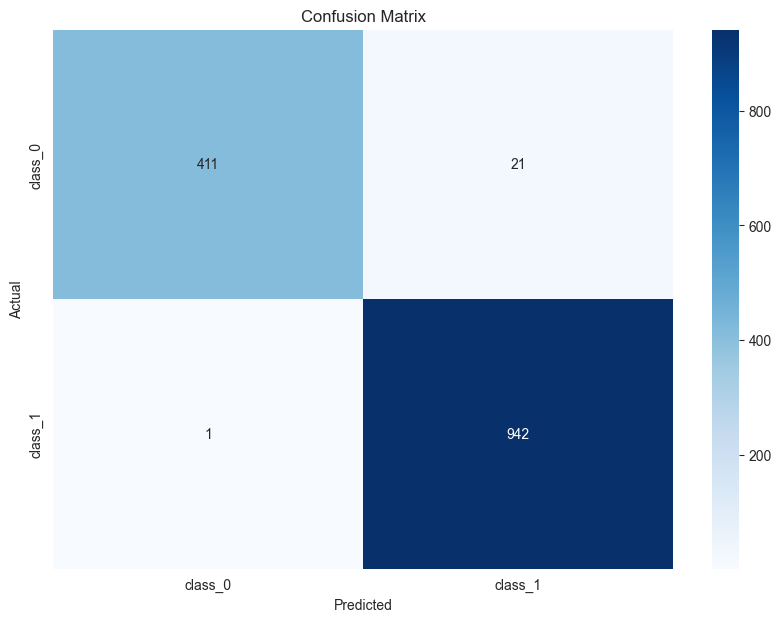

Classification Report:
               precision    recall  f1-score   support

     class_0       1.00      0.95      0.97       432
     class_1       0.98      1.00      0.99       943

    accuracy                           0.98      1375
   macro avg       0.99      0.98      0.98      1375
weighted avg       0.98      0.98      0.98      1375

AUC: 0.995760673186442


NameError: name 'precision_score' is not defined

In [28]:
# Assuming model_mobilenet_attention is already trained and test_generator is predefined

# Generate predictions
y_pred_probs = model_mobilenet_attention.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

# Compute classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Compute AUC
auc = roc_auc_score(y_true, y_pred_probs[:, 1])
print(f"AUC: {auc}")

# Compute Precision, Recall, F1 Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
